In the quest for efficiency and effectiveness in urban transportation, finding the optimal routes to take passengers from their initial locations to their desired destinations is paramount. This challenge is not just about reducing travel time; it's about enhancing the overall experience for both drivers and passengers, ensuring safety, and minimizing environmental impact.

You have been asked to revolutionize the way taxis navigate the urban landscape, ensuring passengers reach their destinations swiftly, safely, and satisfactorily. As an initial step, your goal is to build a reinforcement learning agent that solves this problem within a simulated environment.

The Taxi-v3 environment
The Taxi-v3 environment is a strategic simulation, offering a grid-based arena where a taxi navigates to address daily challenges akin to those faced by a taxi driver. This environment is defined by a 5x5 grid where the taxi's mission involves picking up a passenger from one of four specific locations (marked as Red, Green, Yellow, and Blue) and dropping them off at another designated spot. The goal is to accomplish this with minimal time on the road to maximize rewards, emphasizing the need for route optimization and efficient decision-making for passenger pickup and dropoff.

Key Components:
Action Space: Comprises six actions where 0 moves the taxi south, 1 north, 2 east, 3 west, 4 picks up a passenger, and 5 drops off a passenger.
Observation Space: Comprises 500 discrete states, accounting for 25 taxi positions, 5 potential passenger locations, and 4 destinations.
Rewards System: Includes a penalty of -1 for each step taken without other rewards, +20 for successful passenger delivery, and -10 for illegal pickup or dropoff actions. Actions resulting in no operation, like hitting a wall, also incur a time step penalty.

In [1]:
import numpy as np
import gymnasium as gym
import imageio
from IPython.display import Image, display
from gymnasium.utils import seeding


In [2]:
# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode='rgb_array')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>

In [3]:
# Seed the environment for reproducibility
env.np_random, _ = seeding.np_random(42)
env.action_space.seed(42)
np.random.seed(42)

In [4]:
# Maximum number of actions per training episode
max_actions = 100

total_episodes = 2000
alpha = 0.1
gamma = 0.95
epsilon = 0.9
min_epsilon = 0.01
epsilon_decay = 0.999

In [5]:
n_actions = env.action_space.n
n_states = env.observation_space.n

n_actions, n_states

(6, 500)

In [6]:
Q = np.zeros((n_states, n_actions))
Q.shape

(500, 6)

In [7]:
def update_q_table(state, action, next_state, reward):
  	# Get the old value of the current state-action pair
    old_value = Q[state, action]
    # Determine the maximum Q-value for the next state
    next_max = max(Q[next_state])
    # Compute the new value of the current state-action pair
    Q[state, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)


In [8]:
def epsilon_greedy(q_table, state, epsilon):
    # Implement the condition to explore
    if np.random.rand() < epsilon:
      	# Choose a random action
        action = env.action_space.sample()
    else:
      	# Choose the best action according to q_table
        action = np.argmax(q_table[state])
    return action

In [9]:
episodes_rewards = []

for episode in range(total_episodes):
    state, info = env.reset()
    episode_reward = 0
    for i in range(max_actions):
        action = epsilon_greedy(Q, state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward        
        update_q_table(state, action, next_state, reward)      
        state = next_state
        if terminated:
            break
    episodes_rewards.append(episode_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)


In [10]:
chunk_len = 100
[np.max(episodes_rewards[i:i+chunk_len]) for i in range(0, total_episodes, chunk_len)]

[-105,
 -107,
 -23,
 -41,
 -36,
 -22,
 -16,
 13,
 15,
 9,
 13,
 15,
 13,
 13,
 14,
 14,
 14,
 13,
 14,
 12]

In [11]:
Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -3.38709199,  -3.6220944 ,  -3.75471515,  -3.44033383,
          4.92371733, -10.43427191],
       [ -1.07106867,   1.48491614,  -0.26764862,  -1.66344093,
         10.94067644,  -6.23030863],
       ...,
       [ -1.1544169 ,  -0.38467639,  -1.14145584,  -1.25306048,
         -5.98265883,  -4.29477717],
       [ -2.68350294,  -2.72416213,  -2.78188062,  -1.30418739,
         -8.93231303,  -9.10601454],
       [  1.61101876,   1.23646613,   3.96492135,  17.90875824,
         -1.09738112,  -1.64795938]])

In [12]:
policy = {state: np.argmax(Q[state]) for state in range(n_states)}
len(policy)

500

In [13]:
frames = []
action_count = 0
episode_total_reward = 0
# Run a single episode
state, info = env.reset()
terminated = False
while not terminated and action_count < max_actions:    # Render the environment and capture the frame
    frame = env.render()  
    frames.append(frame) 

    action = policy[state]
    state, reward, terminated, truncated, info = env.step(action)
    episode_total_reward += reward

    action_count += 1

print('episode_total_reward:', episode_total_reward)

np.array(frames).shape

# "should be around 10": Number of frames, equivalent to the steps captured during the episode.
# 350, 550: Height and width (in pixels) of each frame.
# 3: RGB color channels, indicating that the frames are colored images.

episode_total_reward: 8


(13, 350, 550, 3)

In [14]:
# Save frames as a GIF
imageio.mimsave('taxi_agent_behavior.gif', frames, fps=2)

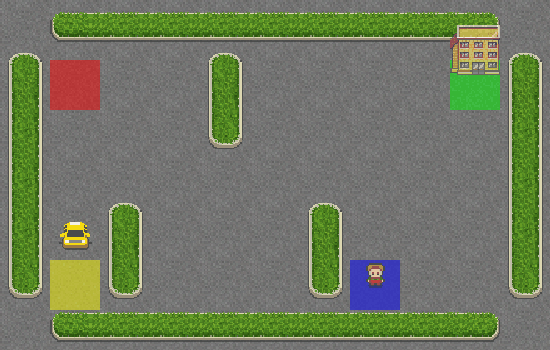

In [15]:
gif_path = "taxi_agent_behavior.gif"
display(Image(filename=gif_path))